In [1]:
pip install gymnasium


Note: you may need to restart the kernel to use updated packages.


In [1]:
from ale_py import ALEInterface
import gymnasium as gym
import ale_py
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt 
ale = ALEInterface()

A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


### Example Usage

In [3]:


gym.register_envs(ale_py)

env = gym.make('ALE/Tetris-v5', render_mode="human")
obs, info = env.reset()
for _ in range(1000):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated: 
        obs, info = env.reset()
env.close()


A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


KeyboardInterrupt: 

: 

In [2]:
def discretize_state(state):
    return tuple(state.tolist())

In [3]:
class MCDPAgent:
    def __init__(self, action_space, epsilon=0.1, gamma=1.0):
        self.action_space = action_space
        self.epsilon = epsilon       
        self.gamma = gamma         
        # Q-value: mapping state -> vector of action values (one entry per action)
        self.Q = defaultdict(lambda: np.zeros(action_space.n))
        # Returns: mapping (state, action) -> list of returns observed
        self.returns = defaultdict(list)
        # Policy: mapping state -> action (best action so far)
        self.policy = {}
    
    def choose_action(self, state):
        """Epsilon-greedy action selection."""
        if np.random.rand() < self.epsilon:
            return self.action_space.sample()
        else:
            return self.policy.get(state, self.action_space.sample())
    
    def update_policy(self, state):
        """Update the policy for a given state as the action with highest Q-value."""
        q_values = self.Q[state]
        best_action = int(np.argmax(q_values))
        self.policy[state] = best_action
    
    def update(self, episode):
        """
        Perform first-visit Monte Carlo update.
        `episode` is a list of (state, action, reward) tuples.
        """
        G = 0
        visited_state_actions = set()
        q_change_total = 0.0
        count = 0
        # Process episode in reverse order.
        for state, action, reward in reversed(episode):
            G = self.gamma * G + reward
            if (state, action) not in visited_state_actions:
                old_value = self.Q[state][action]
                self.returns[(state, action)].append(G)
                self.Q[state][action] = np.mean(self.returns[(state, action)])
                q_change_total += abs(self.Q[state][action] - old_value)
                count += 1
                self.update_policy(state)
                visited_state_actions.add((state, action))
        avg_change = q_change_total / count if count > 0 else 0.0
        return avg_change

def generate_episode(agent, env):
    """Generate an episode by interacting with the environment using the agent's current policy."""
    episode = []
    obs, info = env.reset()
    state = discretize_state(obs)
    done = False
    while not done:
        action = agent.choose_action(state)
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_state = discretize_state(next_obs)
        episode.append((state, action, reward))
        if terminated or truncated:
            break
        state = next_state
    return episode

def train_mcdp(env, num_episodes=500):
    """Train the agent using the MCDP (Monte Carlo Policy Iteration) algorithm."""
    agent = MCDPAgent(env.action_space, epsilon=0.1, gamma=1.0)
    losses = []  # List to store average Q change (loss) per episode
    
    for i in range(num_episodes):
        episode = generate_episode(agent, env)
        episode_loss = agent.update(episode)
        losses.append(episode_loss)
        
        if (i + 1) % 100 == 0:
            print(f"Episode {i+1} completed, average Q loss over last 100 episodes: {np.mean(losses[-100:]):.4f}")
    
    return agent, losses

def evaluate_agent(agent, env, num_episodes=10):
    """Evaluate the learned policy over a number of episodes."""
    total_rewards = []
    for _ in range(num_episodes):
        obs, info = env.reset()
        state = discretize_state(obs)
        episode_reward = 0
        done = False
        while not done:
            action = agent.policy.get(state, env.action_space.sample())
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            state = discretize_state(obs)
            if terminated or truncated:
                break
        total_rewards.append(episode_reward)
    avg_reward = np.mean(total_rewards)
    print(f"Average reward over {num_episodes} evaluation episodes: {avg_reward}")
    return avg_reward



In [4]:
env = gym.make('ALE/Tetris-v5', obs_type="ram", render_mode=None)
agent,losses = train_mcdp(env, num_episodes=3000)
# Evaluate the learned policy
#evaluate_agent(agent, env, num_episodes=10)
env.close()



A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


Episode 100 completed, average Q loss over last 100 episodes: 0.0214
Episode 200 completed, average Q loss over last 100 episodes: 0.0064
Episode 300 completed, average Q loss over last 100 episodes: 0.0052
Episode 400 completed, average Q loss over last 100 episodes: 0.0085
Episode 500 completed, average Q loss over last 100 episodes: 0.0011
Episode 600 completed, average Q loss over last 100 episodes: 0.0089
Episode 700 completed, average Q loss over last 100 episodes: 0.0124
Episode 800 completed, average Q loss over last 100 episodes: 0.0068
Episode 900 completed, average Q loss over last 100 episodes: 0.0276
Episode 1000 completed, average Q loss over last 100 episodes: 0.0014
Episode 1100 completed, average Q loss over last 100 episodes: 0.0063
Episode 1200 completed, average Q loss over last 100 episodes: 0.0101
Episode 1300 completed, average Q loss over last 100 episodes: 0.0083
Episode 1400 completed, average Q loss over last 100 episodes: 0.0096


In [4]:
def plot_losses(losses, interval=100):
    """
    Plots the average loss every 'interval' episodes.
    
    Parameters:
        losses (list or np.array): A list/array of loss values per episode.
        interval (int): The number of episodes to average over (default is 100).
    """
    losses = np.array(losses)
    num_points = len(losses) // interval
    averaged_losses = [np.mean(losses[i*interval:(i+1)*interval]) for i in range(num_points)]
    episodes = np.arange(interval, num_points*interval+1, interval)
    
    plt.figure(figsize=(10, 5))
    plt.plot(episodes, averaged_losses, marker='o', linestyle='-', label='Avg Loss per {} Episodes'.format(interval))
    plt.xlabel('Episode')
    plt.ylabel('Average Loss')
    plt.title('Training Loss Over Episodes')
    plt.legend()
    plt.grid(True)
    plt.show()

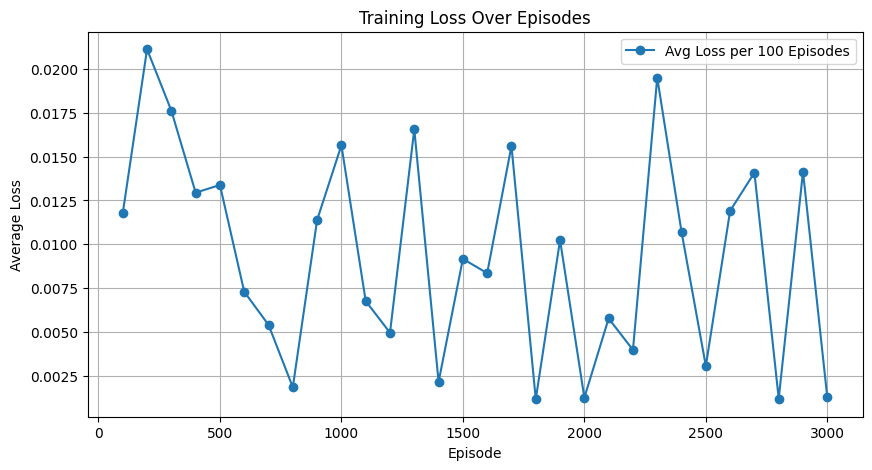

In [22]:
plot_losses(losses)

Losses seem to have gone done somewhat. Let's get a look at the agent!

In [20]:
env = gym.make('ALE/Tetris-v5', obs_type="ram", render_mode="human")
evaluate_agent(agent, env, num_episodes=1)


Evaluation: Average reward over 1 episodes: 1.00


np.float64(1.0)

## As we can see, Monte Carlo Training the agent results in pretty poor performance.

I hypothesize that this is because the state space is very massive; my napkin math estimate says there are roughly 2000 board states, with 7 next pieces for over 10,000 states to explore. As a result, we will pivot to a temporal difference method to see if the state space can be epxlored more fully and continuously by bootstrapping value estimates.


SARSA Update policy:
$$
Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma Q(s',a') - Q(s,a) \right]
$$

In [8]:
class TD0SarsaAgent:
    def __init__(self, action_space, epsilon=0.1, gamma=1.0, alpha=0.5):
        self.action_space = action_space
        self.epsilon = epsilon       # exploration probability
        self.gamma = gamma           # discount factor
        self.alpha = alpha           # learning rate
        # Q-value: mapping state -> vector of action values
        self.Q = defaultdict(lambda: np.zeros(action_space.n))
    
def choose_action(self, state):
    """Epsilon-greedy action selection with random tie-breaking."""
    if np.random.rand() < self.epsilon:
        return self.action_space.sample()
    else:
        q_vals = self.Q[state]
        max_val = np.max(q_vals)
        # Identify all actions that have the maximum Q-value
        max_actions = np.flatnonzero(q_vals == max_val)
        return np.random.choice(max_actions)

    
    def update(self, state, action, reward, next_state, next_action):
        """
        Perform TD(0) update (SARSA).
        Returns the absolute TD error for monitoring.
        """
        td_target = reward + self.gamma * self.Q[next_state][next_action]
        td_error = td_target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error
        return abs(td_error)

def run_episode(agent, env):
    """Run one episode using the agent's current policy.
       Returns the total reward and average TD error over the episode."""
    episode_td_errors = []
    obs, info = env.reset()
    state = discretize_state(obs)
    action = agent.choose_action(state)
    total_reward = 0
    done = False
    while not done:
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_state = discretize_state(next_obs)
        next_action = agent.choose_action(next_state)
        td_err = agent.update(state, action, reward, next_state, next_action)
        episode_td_errors.append(td_err)
        total_reward += reward
        if terminated or truncated:
            break
        state, action = next_state, next_action
    avg_td_error = np.mean(episode_td_errors) if episode_td_errors else 0.0
    return total_reward, avg_td_error

def train_td0(agent, env, num_episodes=500):
    """Train the TD(0) agent over a number of episodes.
       Returns lists of total rewards and average TD errors per episode."""
    rewards = []
    td_errors = []
    for i in range(num_episodes):
        ep_reward, ep_td_error = run_episode(agent, env)
        rewards.append(ep_reward)
        td_errors.append(ep_td_error)
        if (i + 1) % 100 == 0:
            print(f"Episode {i+1} completed: avg reward over last 100 eps = {np.mean(rewards[-100:]):.2f}, "
                  f"avg TD error = {np.mean(td_errors[-100:]):.4f}")
    return rewards, td_errors

def evaluate_agent(agent, env, num_episodes=10):
    """Evaluate the learned policy over a given number of episodes.
       Returns the average reward."""
    total_rewards = []
    for _ in range(num_episodes):
        obs, info = env.reset()
        state = discretize_state(obs)
        episode_reward = 0
        done = False
        while not done:
            # Greedy action selection
            action = int(np.argmax(agent.Q[state]))
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            state = discretize_state(obs)
            if terminated or truncated:
                break
        total_rewards.append(episode_reward)
    avg_reward = np.mean(total_rewards)
    print(f"Average reward over {num_episodes} evaluation episodes: {avg_reward}")
    return avg_reward

In [9]:
train_env = gym.make('ALE/Tetris-v5', obs_type="ram", render_mode=None)
agent = TD0SarsaAgent(train_env.action_space, epsilon=0.1, gamma=1.0, alpha=0.1)
rewards, td_errors = train_td0(agent, train_env, num_episodes=3000)
train_env.close()

Episode 100 completed: avg reward over last 100 eps = 0.00, avg TD error = 0.0000
Episode 200 completed: avg reward over last 100 eps = 0.00, avg TD error = 0.0000
Episode 300 completed: avg reward over last 100 eps = 0.00, avg TD error = 0.0000
Episode 400 completed: avg reward over last 100 eps = 0.00, avg TD error = 0.0000
Episode 500 completed: avg reward over last 100 eps = 0.00, avg TD error = 0.0000
Episode 600 completed: avg reward over last 100 eps = 0.01, avg TD error = 0.0000
Episode 700 completed: avg reward over last 100 eps = 0.00, avg TD error = 0.0000
Episode 800 completed: avg reward over last 100 eps = 0.00, avg TD error = 0.0000
Episode 900 completed: avg reward over last 100 eps = 0.01, avg TD error = 0.0000
Episode 1000 completed: avg reward over last 100 eps = 0.00, avg TD error = 0.0000
Episode 1100 completed: avg reward over last 100 eps = 0.00, avg TD error = 0.0000
Episode 1200 completed: avg reward over last 100 eps = 0.00, avg TD error = 0.0000
Episode 1300 

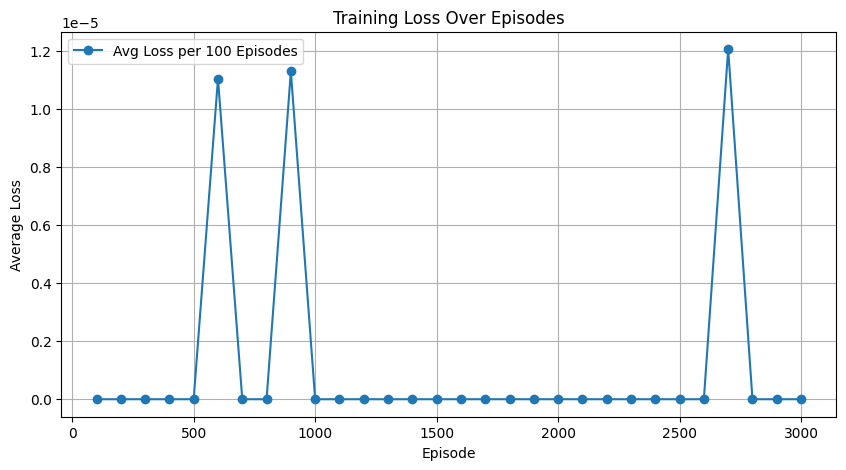

In [14]:
plot_losses(td_errors)

What the heck! Let's get a look at the agent!

In [15]:
env = gym.make('ALE/Tetris-v5', obs_type="ram", render_mode="human")
evaluate_agent(agent, env, num_episodes=1)


Average reward over 1 evaluation episodes: 0.0


np.float64(0.0)

In [ ]:
env.close()

: 

## TD(0) is also displaying poor performance. We will try Q-learning, as a last-resort

Q-learning policy update: 

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \left[ r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right]
$$

In [ ]:

# Register ALE environments with Gymnasium
gym.register_envs(ale_py)

def discretize_state(state):
    """
    Convert the 128-byte RAM state (a NumPy array) into a hashable tuple.
    """
    return tuple(state.tolist())

class QLearningAgent:
    def __init__(self, action_space, alpha=0.5, gamma=1.0, 
                 epsilon=1.0, epsilon_min=0.1, decay=0.995):
        self.action_space = action_space
        self.alpha = alpha      # Learning rate
        self.gamma = gamma      # Discount factor
        self.epsilon = epsilon  # Initial exploration probability
        self.epsilon_min = epsilon_min
        self.decay = decay
        # Q-values: mapping from state to a vector of action values
        self.Q = defaultdict(lambda: np.zeros(action_space.n))
        
    def choose_action(self, state):
        """
        Epsilon-greedy action selection.
        """
        if np.random.rand() < self.epsilon:
            return self.action_space.sample()
        else:
            return int(np.argmax(self.Q[state]))
        
    def update(self, state, action, reward, next_state, done):
        """
        Q-learning update:
            Q(s,a) <- Q(s,a) + alpha * [r + gamma * max_a' Q(s', a') - Q(s,a)]
        Returns the absolute TD error.
        """
        best_next = 0 if done else np.max(self.Q[next_state])
        td_target = reward + self.gamma * best_next
        td_error = td_target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error
        return abs(td_error)
    
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.decay

def run_episode(agent, env):
    """
    Run one episode using the agent's current policy.
    Returns total reward and average TD error for the episode.
    """
    total_reward = 0
    td_errors = []
    obs, info = env.reset()
    state = discretize_state(obs)
    done = False
    while not done:
        action = agent.choose_action(state)
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_state = discretize_state(next_obs)
        abs_td_error = agent.update(state, action, reward, next_state, (terminated or truncated))
        td_errors.append(abs_td_error)
        total_reward += reward
        state = next_state
        if terminated or truncated:
            break
    agent.decay_epsilon()
    avg_td_error = np.mean(td_errors) if td_errors else 0.0
    return total_reward, avg_td_error

def train_qlearning(env, num_episodes=500):
    """
    Train the Q-learning agent over a given number of episodes.
    Returns the trained agent, rewards per episode, and average TD error per episode.
    """
    agent = QLearningAgent(env.action_space, alpha=0.1, gamma=1.0, 
                           epsilon=1.0, epsilon_min=0.1, decay=0.995)
    rewards = []
    td_losses = []
    for i in range(num_episodes):
        ep_reward, ep_td_error = run_episode(agent, env)
        rewards.append(ep_reward)
        td_losses.append(ep_td_error)
        if (i+1) % 100 == 0:
            print(f"Episode {i+1} completed: "
                  f"Avg reward (last 100): {np.mean(rewards[-100:]):.2f}, "
                  f"Avg TD error: {np.mean(td_losses[-100:]):.4f}, "
                  f"Epsilon: {agent.epsilon:.4f}")
    return agent, rewards, td_losses

def evaluate_agent(agent, env, num_episodes=10):
    """
    Evaluate the learned policy over a number of episodes and return the average reward.
    Uses greedy (non-exploratory) action selection.
    """
    total_rewards = []
    for _ in range(num_episodes):
        obs, info = env.reset()
        state = discretize_state(obs)
        episode_reward = 0
        done = False
        while not done:
            action = int(np.argmax(agent.Q[state]))
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            state = discretize_state(obs)
            if terminated or truncated:
                break
        total_rewards.append(episode_reward)
    avg_reward = np.mean(total_rewards)
    print(f"Evaluation: Average reward over {num_episodes} episodes: {avg_reward:.2f}")
    return avg_reward




In [6]:
train_env = gym.make('ALE/Tetris-v5', obs_type="ram", render_mode=None)
agent, rewards, losses = train_qlearning(train_env, num_episodes=3000)
train_env.close()

A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


Episode 100 completed: Avg reward (last 100): 0.01, Avg TD error: 0.0000, Epsilon: 0.6058
Episode 200 completed: Avg reward (last 100): 0.01, Avg TD error: 0.0000, Epsilon: 0.3670
Episode 300 completed: Avg reward (last 100): 0.00, Avg TD error: 0.0000, Epsilon: 0.2223
Episode 400 completed: Avg reward (last 100): 0.00, Avg TD error: 0.0000, Epsilon: 0.1347
Episode 500 completed: Avg reward (last 100): 0.00, Avg TD error: 0.0000, Epsilon: 0.0997
Episode 600 completed: Avg reward (last 100): 0.00, Avg TD error: 0.0000, Epsilon: 0.0997
Episode 700 completed: Avg reward (last 100): 0.00, Avg TD error: 0.0000, Epsilon: 0.0997
Episode 800 completed: Avg reward (last 100): 0.00, Avg TD error: 0.0000, Epsilon: 0.0997
Episode 900 completed: Avg reward (last 100): 0.00, Avg TD error: 0.0000, Epsilon: 0.0997
Episode 1000 completed: Avg reward (last 100): 0.00, Avg TD error: 0.0000, Epsilon: 0.0997
Episode 1100 completed: Avg reward (last 100): 0.00, Avg TD error: 0.0000, Epsilon: 0.0997
Episode 

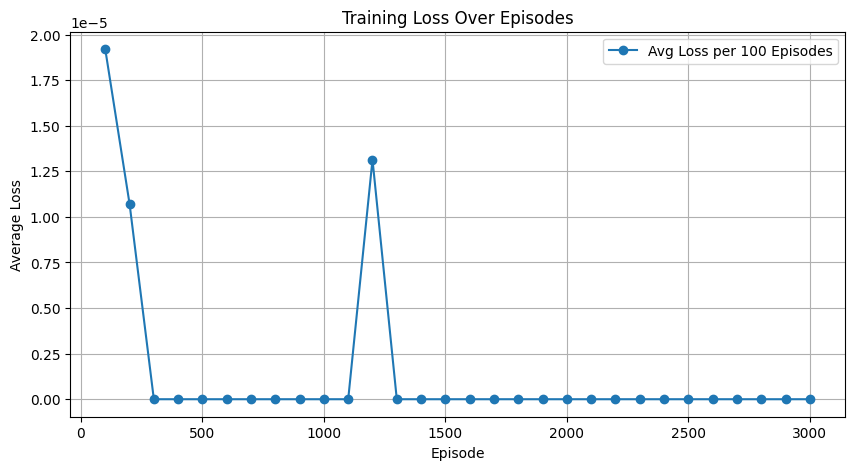

In [7]:
plot_losses(losses)

What the heck! Let's get a look at the agent!

In [8]:
env = gym.make('ALE/Tetris-v5', obs_type="ram", render_mode="human")
evaluate_agent(agent, env, num_episodes=1)


Evaluation: Average reward over 1 episodes: 0.00


np.float64(0.0)

It's real bad!

In [9]:
env.close()

: 